# Пространственные преобразования изображения

## Представление изображения

Изображение в памяти представляется многомерным массивом. Мы будем использовать порядок укладывания H,W,C: строка, столбец, канал.
В работе с изображениями нам помогут библиотеки [OpenCV](https://opencv.org/), [Numpy](https://numpy.org/) и [Matplotlib](https://matplotlib.org/).

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Изображение - это просто функция из пространства координат пикселей в значения яркостей каналов:

$$
I : [0, W] \times [0, H] \rightarrow [0, 255]^3
$$

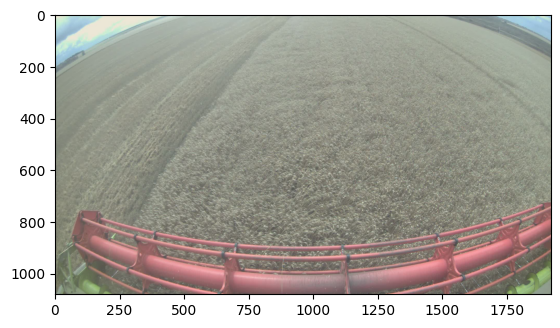

In [6]:
i = cv2.imread("../data/warping_transforms/img.png")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
img = i
plt.imshow(i)

Преобразования изображения могут быть разными. Например, гамма-коррекция относится к яркостным:

$$
\tilde I (x, y) = I^\gamma(x, y)
$$

Здесь мы будем рассматривать **пространственные** (spatial) преобразования изображения, то есть те, которые получены заменой координат:

$$
\tilde I (x, y) = I(\tilde x (x,y), \tilde y (x, y))
$$

Пространственные преобразования изображения характеризуются функцией преобразования координат.

$$
\left(
\begin{array}{c}
    \tilde x (x, y) \\
    \tilde y (x, y) 
\end{array}
\right)
$$

Эти функции пересчета координат можно задавать аналитически или использовать предвычисленные изображения - карты пересчета.

Любое пространственное преобрзование изображения (и их комбинаию) можно представить его картами пересчета.

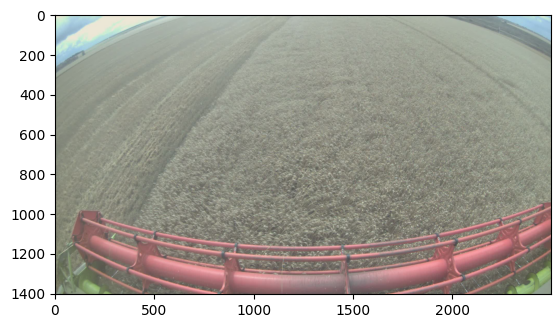

In [7]:
# Пример: карта пересчета для преобразования resize
img_scaled_by_opencv = cv2.resize(i, None, fx=1.3, fy=1.3)
sz = img_scaled_by_opencv.shape
plt.imshow(img_scaled_by_opencv)


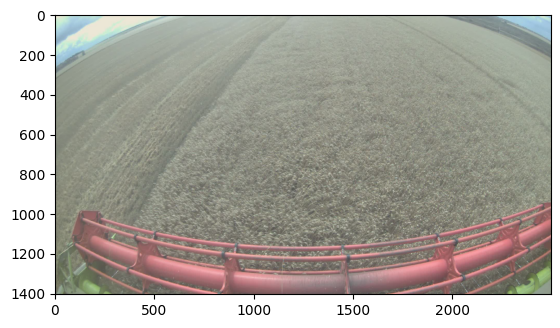

In [8]:
class ResizeRemap:
    def __init__(self, s):
        self.s = s
    
    def x(self, x, y):
        return x / self.s
    
    def y(self, x, y):
        return y / self.s

img_scaled_by_loop = np.zeros_like(img_scaled_by_opencv)
remap = ResizeRemap(1.3)

for x in np.arange(0, sz[1]):
    for y in np.arange(0, sz[0]):
        img_scaled_by_loop[y, x, :] = i[int(remap.y(x, y)), int(remap.x(x, y)), :]

plt.imshow(img_scaled_by_loop)

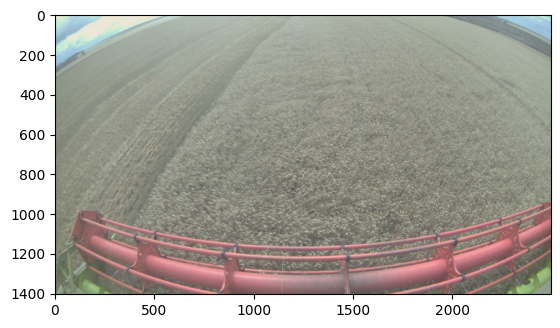

In [9]:
# или через функцию cv::remap, предварительно рассчитав карты пересчета:
rmap_x = np.zeros(shape=(sz[0], sz[1]), dtype=np.float32)
rmap_y = np.zeros(shape=(sz[0], sz[1]), dtype=np.float32)

for x in np.arange(0, sz[1]):
    for y in np.arange(0, sz[0]):
        rmap_x[y, x] = remap.x(x, y)
        rmap_y[y, x] = remap.y(x, y)

img_scaled_by_remap = cv2.remap(i, rmap_x, rmap_y, interpolation=cv2.INTER_NEAREST)
plt.imshow(img_scaled_by_remap)

## Интерполяция

В последнем вызове был указан параметр типа интерполяции. 
Вычисленные значения карт пересчета могут попадать в дробные значения пикселей.
Поэтому вычисление значения яркости требует интерполяции значений дискретной сетки в искомых координатах.

Наиболее распространенные способы интерполяции это интерполяция по ближайшему соседу и билинейная интерполяция.

![интерполяция](../data/warping_transforms/bilinear.png)

В случае использования билинейной интерполяции интенсивность будет вычисляться как взвешанная сумма соседних пикселей.

![билинейная интерполяция](../data/warping_transforms/bilinear_2.png)

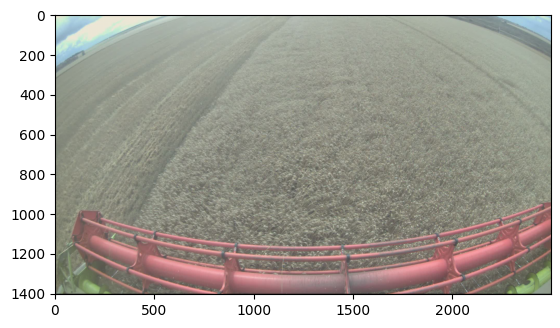

In [10]:
import math

def bilinear_kernel(src, x, y):
    x1 = int(math.floor(x))
    y1 = int(math.floor(y))
    x2 = min(x1 + 1, src.shape[1] - 1)
    y2 = min(y1 + 1, src.shape[0] - 1)

    i_11 = src[y1, x1, :]
    i_12 = src[y2, x1, :]
    i_21 = src[y1, x2, :]
    i_22 = src[y2, x2, :]

    return i_11 * (x2 - x) * (y2 - y) + \
           i_12 * (x2 - x) * (y - y1) + \
           i_21 * (x - x1) * (y2 - y) + \
           i_22 * (x - x1) * (y - y1)


img_scaled_by_loop_bilinear = np.zeros_like(img_scaled_by_opencv)
remap = ResizeRemap(1.3)

for x in np.arange(0, sz[1]):
    for y in np.arange(0, sz[0]):
        img_scaled_by_loop_bilinear[y, x, :] = bilinear_kernel(i, remap.x(x, y), remap.y(x, y))

plt.imshow(img_scaled_by_loop_bilinear)

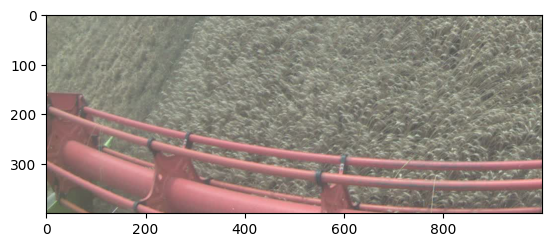

In [11]:
# упражнение с аудиторией: вычислить карту remap для преобразования `crop` (вычисление ROI)

roi_x = 100
roi_y = 600
roi_w = 1000
roi_h = 400

roi_i = i[roi_y : roi_y + roi_h, roi_x : roi_x + roi_w, :]
plt.imshow(roi_i)

In [12]:
class RoiRemap:
    def __init__(self, x, y, w, h):
        self.x0 = x
        self.y0 = y
        self.w = w
        self.h = h
    
    def x(self, x, y):
        if x >= self.w or y >= self.h:
            return 0.0
        return x + self.x0

    def y(self, x, y):
        if x >= self.w or y >= self.h:
            return 0.0
        return y + self.y0

In [13]:
roi_remapper = RoiRemap(roi_x, roi_y, roi_w, roi_h)
rmap_x = np.zeros(shape=(roi_h, roi_w), dtype=np.float32)
rmap_y = np.zeros(shape=(roi_h, roi_w), dtype=np.float32)

for x in np.arange(0, roi_w):
    for y in np.arange(0, roi_h):
        rmap_x[y, x] = roi_remapper.x(x, y)
        rmap_y[y, x] = roi_remapper.y(x, y)

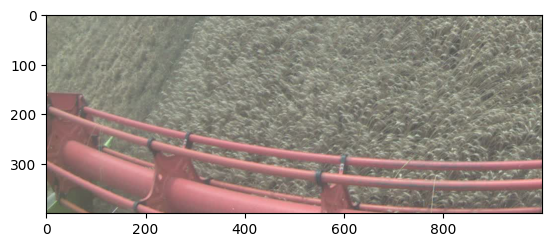

In [14]:
plt.imshow(cv2.remap(img, rmap_x, rmap_y, cv2.INTER_NEAREST))

## Более сложные преобразования

планчик:

* карты пересчета cv::remap
* карты пересчета для resize и crop
* интерполяция
* модуль определителя якобиана как способ оценить ошибку пространственного преобразования
* проективное преобразование и модуль якобиана

Зададим параметры калибровки для дальнейшего изучения

In [15]:
# Параметры центральной проекции
f_x = 943.37 # пиксельное фокусное расстояние по оси X
f_y = 943.37 # пиксельное фокусное расстояние по оси Y
u_x = 990.38 # координаты центрального пикселя (principal point) по X 
u_y = 487.67 # координаты центрального пикселя (principal point) по Y

# Матрица центральной проекции
K = np.array(
    [
        [f_x, 0.0, u_x],
        [0.0, f_y, u_y],
        [0.0, 0.0, 1.0]
    ],
    dtype=np.float32 # opencv работает с float32
)

# Параметры радиальной дисторсии
k_1 = -0.3229
k_2 = 0.1042
k_3 = -0.0148

D = np.array([k_1, k_2, 0.0, 0.0, k_3], dtype=np.float32)

# Размеры изображения
image_size = (1920, 1080)

# Углы поворота с.к. камеры
r_1 = -0.6344
r_2 = -0.0416
r_3 = 0.0157

# координаты установки камеры в с.к. робота
t_1 = -0.378
t_2 = -3.915
t_3 = 2.400

print('K = ', K)
print('D = ', D)
print('image_size = ', image_size)


K =  [[943.37   0.   990.38]
 [  0.   943.37 487.67]
 [  0.     0.     1.  ]]
D =  [-0.3229  0.1042  0.      0.     -0.0148]
image_size =  (1920, 1080)


## Bird's eye view

In [16]:
import numpy.linalg
# матрица поворота
R = np.linalg.inv(cv2.Rodrigues(np.array([r_1, r_2, r_3], dtype=np.float32))[0])

t = np.array([[t_1], [t_2], [t_3]], dtype=np.float32)
RT = np.hstack((R, -R@t))
print(f"R|t = \n{RT}")

# матрица камеры наблюдения
P = K @ RT
print(f"P = \n{P}")

def proj_pt(P, r):
    h_pix = P @ np.hstack((r, [1]))
    return (h_pix[0] / h_pix[2], h_pix[1] / h_pix[2])

print(proj_pt(P, [0,0,5]))
print(proj_pt(P, [0,0,6]))
print(proj_pt(P, [0,0,7]))
print(proj_pt(P, [3,0,10]))
print(proj_pt(P, [3,0,20]))

R|t = 
[[ 9.9904436e-01  2.7419649e-02  3.4037601e-02  4.0329644e-01]
 [-1.9061693e-03  8.0534059e-01 -5.9280938e-01  4.5749302e+00]
 [-4.3666486e-02  5.9217793e-01  8.0462325e-01  3.7077472e-01]]
P = 
[[ 8.9922205e+02  6.1234808e+02  8.2899280e+02  7.4766565e+02]
 [-2.3093060e+01  1.0485216e+03 -1.6684796e+02  4.4966680e+03]
 [-4.3666486e-02  5.9217793e-01  8.0462325e-01  3.7077472e-01]]
(1113.5072985589568, 833.5273236663749)
(1100.626491296602, 672.4190932676339)
(1091.1986107937926, 554.4987554129159)
(1416.274297683276, 332.9600054424615)
(1226.1139635393888, 66.7654620188756)


In [17]:
# матрица камеры проекции: такая же камер, но висящая над сценой и смотрящая вниз
r1_beye = -0.5 * np.pi
r2_beye = 0.0
r3_beye = 0.0

t1_beye = 0.0
t2_beye = -10 # висеть будем на высоте 10 м
t3_beye = 10 # и на 10 м вперед относительно начала координат

In [18]:
# матрица поворота
R_beye = np.linalg.inv(cv2.Rodrigues(np.array([r1_beye, r2_beye, r3_beye], dtype=np.float32))[0])

t_beye = np.array([[t1_beye], [t2_beye], [t3_beye]], dtype=np.float32)
RT_beye = np.hstack((R_beye, -R_beye@t_beye))
print(f"R|t = \n{RT_beye}")

# матрица камеры наблюдения
P_beye = K @ RT_beye
print(f"P = \n{P_beye}")

R|t = 
[[ 1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [-0.000000e+00 -4.371139e-08 -1.000000e+00  1.000000e+01]
 [ 0.000000e+00  1.000000e+00 -4.371139e-08  1.000000e+01]]
P = 
[[ 9.4337000e+02  9.9038000e+02 -4.3290886e-05  9.9037998e+03]
 [ 0.0000000e+00  4.8766998e+02 -9.4337000e+02  1.4310400e+04]
 [ 0.0000000e+00  1.0000000e+00 -4.3711388e-08  1.0000000e+01]]


In [19]:
# уравнение плоскости проекции
plane = np.array([0,1,0,0], dtype=np.float32) # Y = 0

# применим формулы для вычисления гомографии с предыдущей лекции
P_plane = np.vstack((P_beye, plane))
H = P @ np.linalg.inv(P_plane)[:, :3]

print(H)

[[ 9.5320189e-01 -8.7875682e-01  3.8827081e+02]
 [-2.4479324e-02  1.7686374e-01  2.2081152e+02]
 [-4.6287762e-05 -8.5292436e-04  1.3034890e+00]]


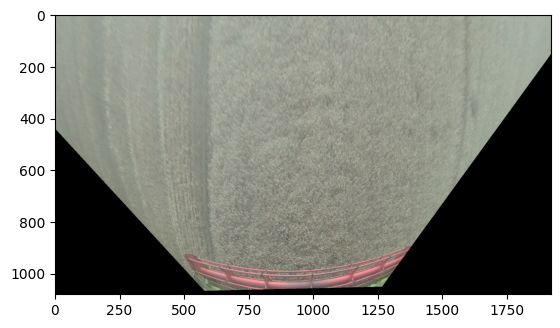

In [20]:
class BirdeyeRemap:
    def __init__(self, H):
        self.H = H
    
    def proj(self, x, y):
        pt_homo = self.H @ np.array([x, y, 1], dtype=np.float32).T
        return (pt_homo[0] / pt_homo[2], pt_homo[1] / pt_homo[2])
    
    def x(self, x, y):
        return self.proj(x, y)[0]
    
    def y(self, x, y):
        return self.proj(x, y)[1]

img_homo = np.zeros_like(i)
remapper = BirdeyeRemap(H)

width = image_size[0]
height = image_size[1]

for x in np.arange(0, width):
    for y in np.arange(0, height):
        xx, yy = remapper.proj(x,y)
        if xx >= 0 and xx < width and yy >= 0 and yy < height:
            img_homo[y,x,:] = bilinear_kernel(i, xx, yy)

plt.imshow(img_homo)

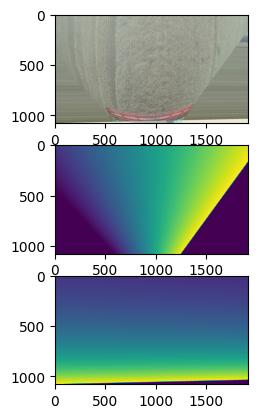

In [21]:
rmap_x_beye = np.zeros([height, width], dtype=np.float32)
rmap_y_beye = np.zeros([height, width], dtype=np.float32)

for x in np.arange(0, width):
    for y in np.arange(0, height):
        xx, yy = remapper.proj(x,y)
        if xx >= 0 and xx < width:
            rmap_x_beye[y, x] = xx
        if yy >= 0 and yy < height:
            rmap_y_beye[y, x] = yy


plt.subplot(311)
remapped_beye = cv2.remap(i, rmap_x_beye, rmap_y_beye, cv2.INTER_LINEAR)
plt.imshow(remapped_beye)
plt.subplot(312)
plt.imshow(rmap_x_beye)
plt.subplot(313)
plt.imshow(rmap_y_beye)

## Радиальная дисторсия

Радиальная дисторсия - особенные нелинейные искажения изображения, вызванные неоднородностями и несовершенствами объектива оптической системы.
На представленном изображении особенно хорошо заметен эффект рыбьего глаза, вызванный использованием широкого объектива.

Для корректной работы математического аппарата центральной проекции необходимо исправлять дисторсию -- делать преобразование **undistort**

Будем изучать поведение преобразования на 

* сетке с константным шагом
* произвольно выбранных точках

Наша цель - изучить как и куда переходят точки при прямом и обратном преобразовании

In [22]:
def draw_grid(img, step, color):
    w = img.shape[1]
    h = img.shape[0]
    start = int(step / 2)
    for i in range(start, w, step):
        cv2.line(img, (i, 0), (i, h - 1), color, 3, cv2.LINE_AA)
    for i in range(start, h, step):
        cv2.line(img, (0, i), (w - 1, i), color, 3, cv2.LINE_AA)
    
    return img

def generate_circles(image_size, n):
    cmap = plt.cm.get_cmap("tab20", n)
    xs = np.random.randint(0, image_size[0] - 1, n)
    ys = np.random.randint(0, image_size[1] - 1, n)
    cmis = np.random.permutation(n)
    colors = [cmap(cmi) for cmi in cmis]
    colors = [(255 * c[0], 255 * c[1], 255 * c[2]) for c in colors]
    return [{'x': x, 'y': y, 'color': color} for x,y,color in zip(xs, ys, colors)]

def draw_circles(image, circles):
    for c in circles:
        cv2.circle(image, (int(c['x']), int(c['y'])), 20, c['color'], -1, cv2.LINE_AA)
    return image
        
def undistort_circles(circles, K, D):
    src = [(c['x'], c['y']) for c in circles]
    src = np.array(src, dtype=np.float32)
    src = src.reshape(-1,1,2)
    dst = cv2.undistortPoints(src, K, D, P=K)
    # print(src, dst)
    res = []
    for i,c in enumerate(circles):
        res.append({'x': dst[i,0,0], 'y': dst[i,0,1], 'color': c['color']})
    return res;
    
def prepare_distortion_grid_images(image_size, K, D):
    #img_src = np.zeros(image_size[-1::-1], dtype=np.uint8)
    img_src = 255 * np.ones((image_size[1], image_size[0], 3), dtype=np.uint8)
    img_src = draw_grid(img_src, step=100, color=(220, 100, 100))
    return img_src

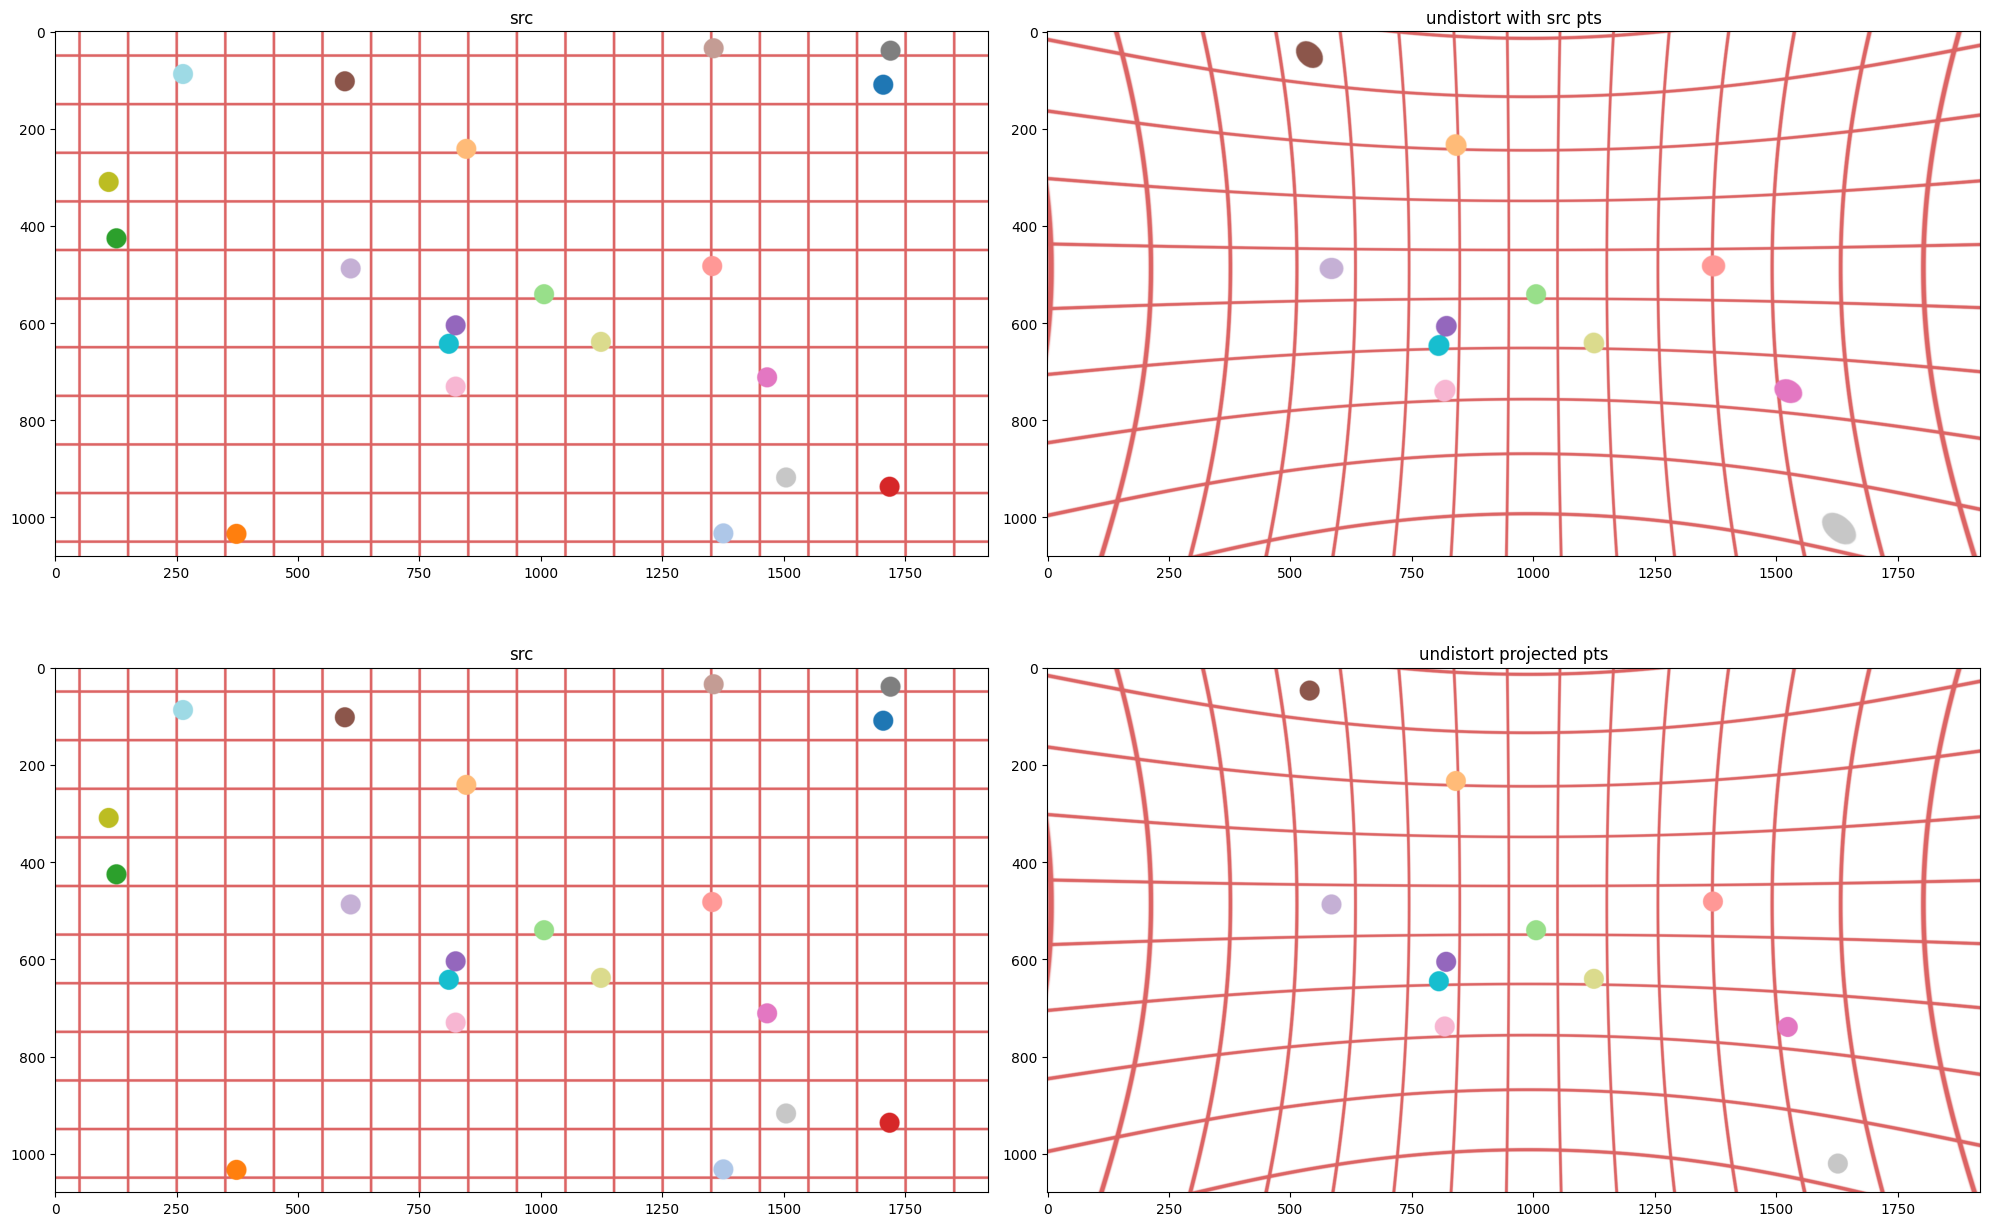

In [24]:
img_src = prepare_distortion_grid_images(image_size, K, D)
img_und = cv2.undistort(img_src, K, D)


circles_src = generate_circles(image_size, 20)
img_src_p = draw_circles(img_src.copy(), circles_src)
img_und_p = cv2.undistort(img_src_p, K, D)
circles_und = undistort_circles(circles_src, K, D)
img_und_p_2 = draw_circles(img_und.copy(), circles_und)

und_img = cv2.undistort(img, K, D)

plt.figure(figsize=(20,13))
plt.subplot(221)
plt.imshow(img_src_p)
plt.title('src')
plt.subplot(222)
plt.imshow(img_und_p)
plt.title('undistort with src pts')
plt.subplot(223)
plt.imshow(img_src_p)
plt.title('src')
plt.subplot(224)
plt.imshow(img_und_p_2)
plt.title('undistort projected pts')
plt.tight_layout()
plt.show()

Не стоит путать картинки: слева (src) изображение с дисторсией. 
Справа - исправленная дисторсия. 

Искажение сетки показывает, куда сдвигаются пиксели исходного изображения при преобразовании

In [25]:
src = i.copy()
und = cv2.undistort(src, K, D)
src_mask = img_src_p != 255
und_mask = img_und_p_2 != 255

und[und_mask] = img_und_p_2[und_mask]
src[src_mask] = img_src_p[src_mask]

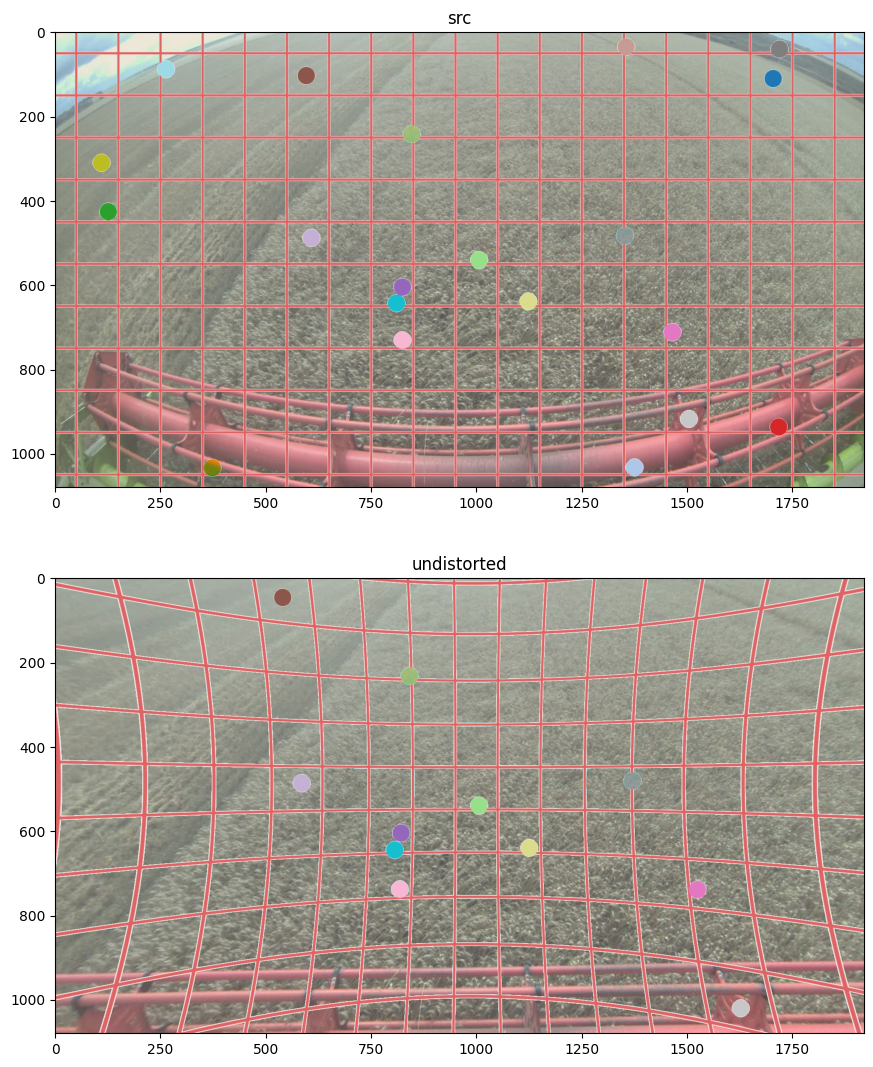

In [26]:
plt.figure(figsize=(20,13))
plt.subplot(211)
plt.imshow(src)
plt.title('src')
plt.subplot(212)
plt.imshow(und)
plt.title('undistorted')
plt.show()

Итак, мы продемонстрировали, как трансформируются точки из src в undistort. Но как узнать прообраз точки на und-изображении?

In [27]:
def distortPoints(src, K, k1, k2, k3, P):
    n = len(src)
    homogenous_points = np.dstack([src, np.ones((n,1,1), dtype=np.float32)])
    h_p = homogenous_points.reshape(n,-1).T
    uniform_coords = np.linalg.inv(K) @ h_p
    xs = uniform_coords[0,:]
    ys = uniform_coords[1,:]
    
    r2 = xs ** 2 + ys ** 2
    r4 = r2 ** 2
    r6 = r4 * r2
    coef = (1 + k1 * r2 + k2 * r4 + k3 * r6)
    xs1 = xs * coef
    ys1 = ys * coef
    res = np.vstack([xs1, ys1, np.ones(n, dtype=np.float32)])
    res = P @ res
    res = res[:2].T.reshape(-1,1,2)
    return res

def distort_circles(circles, K, D):
    src = [(c['x'], c['y']) for c in circles]
    src = np.array(src, dtype=np.float32)
    src = src.reshape(-1,1,2)
    dst = distortPoints(src, K, D[0], D[1], D[4], P=K)
    res = []
    for i,c in enumerate(circles):
        res.append({'x': dst[i,0,0], 'y': dst[i,0,1], 'color': c['color']})
    return res;

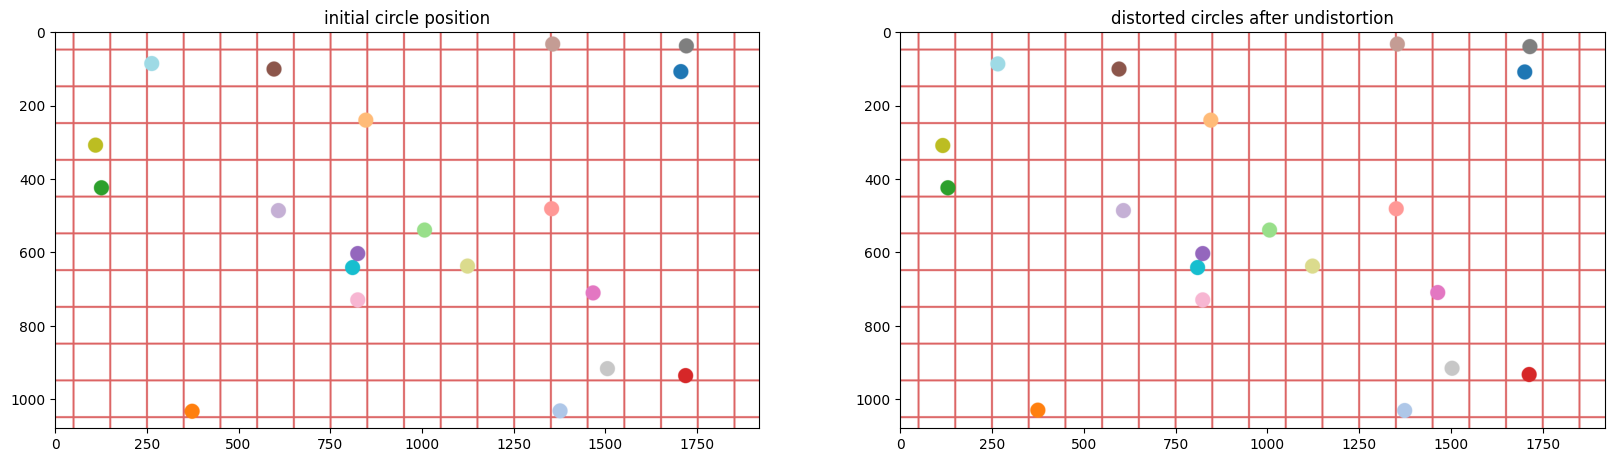

[[ 1.9531250e-02  9.2163086e-03]
 [-4.8167725e+00 -3.4365845e-01]
 [ 0.0000000e+00  0.0000000e+00]
 [ 1.2207031e-04 -3.0517578e-05]
 [ 3.6977539e+00  2.2866211e+00]
 [-2.5471191e+00  2.2540283e+00]
 [-6.1035156e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00]
 [-3.1216431e+00 -1.7152405e+00]
 [ 3.7299805e+00 -2.2917786e+00]
 [-6.1035156e-05 -1.5258789e-05]
 [ 2.5935059e+00 -1.3725586e+00]
 [ 3.6523438e-01  3.0603027e-01]
 [ 5.1147461e-02 -6.3507080e-02]
 [ 2.6171875e-01  3.7109375e-01]
 [ 0.0000000e+00  0.0000000e+00]
 [-6.6159058e+00 -1.3351440e+00]
 [-3.6621094e-04 -3.0517578e-05]
 [-2.9113770e-02 -2.8381348e-02]]


In [29]:
# circles = generate_circles(image_size, 20)
circles_distorted = distort_circles(circles_und, K, D)
img_src_p_2 = draw_circles(img_src.copy(), circles_distorted)
plt.figure(figsize=(20,13))
plt.subplot(121)
plt.imshow(img_src_p)
plt.title('initial circle position')
plt.subplot(122)
plt.imshow(img_src_p_2)
plt.title('distorted circles after undistortion')
plt.show()

p_src1 = np.array([[c['x'], c['y']] for c in circles_src], dtype=np.float32)
p_src2 = np.array([[c['x'], c['y']] for c in circles_distorted], dtype=np.float32)

print(p_src1 - p_src2)

### но как тогда работает функция cv2.undistortPoints?

необходимо обратить функцию `distortPoints`. 


$$
\left(
\begin{matrix}
x_{src} \\
y_{src}
\end{matrix}
\right)
=
\left(
\begin{matrix}
x_{dst} (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
y_{dst} (1 + k_1 r^2 + k_2 r^4 + k_3 r^6)
\end{matrix}
\right)
$$

где $r^2 = x_{dst}^2 + y_{dst}^2$


Воспользуемся пакетом символьных вычислений `sympy`

In [30]:
class DistortFunc:
    def __init__(self, K, D):
        self.k1 = D[0]
        self.k2 = D[1]
        self.k3 = D[4]
        self.fx = K[0,0]
        self.fy = K[1,1]
        self.cx = K[0,2]
        self.cy = K[1,2]
        
        self.F_sym, self.J_sym = self.__symbols()
        self.FN_sym, self.JN_sym = self.__nsymbols()
    
    def F(self, xy):
        return np.array(self.F_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    def J(self, xy):
        return np.array(self.J_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    
    def Fn(self, xy):
        return np.array(self.FN_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    def Jn(self, xy):
        return np.array(self.JN_sym.evalf(subs={self.x:xy[0], self.y:xy[1]}), dtype=np.float32)
    
    def distort_pix(self, x, y):
        x1 = (x - self.cx) / self.fx
        y1 = (y - self.cy) / self.fy
        
        xy2 = self.F([x1,y1])
        x3 = self.fx * xy2[0][0] + self.cx
        y3 = self.fy * xy2[1][0] + self.cy
        return (x3, y3)
    
    def normalize_x(self, x):
        return (x - self.cx) / self.fx
    def normalize_y(self, y):
        return (y - self.cy) / self.fy   
    def unnormalize_x(self, x):
        return self.fx * x + self.cx
    def unnormalize_y(self, y):
        return self.fy * y + self.cy
    
    
    def __symbols(self):
        import sympy as sym

        self.x, self.y = sym.symbols('x, y')
        
        def r2(x, y):
            return x * x + y * y

        def d(x, y):
            r2_ = r2(x, y)
            r4_ = r2_ * r2_
            r6_ = r4_ * r2_
            return 1 + self.k1 * r2_ + self.k2 * r4_ + self.k3 * r6_

        def fx(x, y):
            return x * d(x, y)

        def fy(x, y):
            return y * d(x, y)

        F = sym.Matrix([fx(self.x, self.y), fy(self.x, self.y)])
        J = F.jacobian((self.x, self.y))
        return F,J
    
    def __nsymbols(self):
        import sympy as sym

        self.x, self.y = sym.symbols('x, y')
        
        def r2(x, y):
            return x * x + y * y

        def d(x, y):
            r2_ = r2(x, y)
            r4_ = r2_ * r2_
            r6_ = r4_ * r2_
            return 1 + self.k1 * r2_ + self.k2 * r4_ + self.k3 * r6_

        def fx(x, y):
            return x * d(x, y)

        def fy(x, y):
            return y * d(x, y)
        
        nx = self.normalize_x(self.x)
        ny = self.normalize_y(self.y)
        
        xx = fx(nx, ny)
        yy = fy(nx, ny)
        xxx = self.unnormalize_x(xx)
        yyy = self.unnormalize_y(yy)
        
        F = sym.Matrix([xxx, yyy])
        J = F.jacobian((self.x, self.y))
        return F,J        
        

In [31]:
circles_src[1:5], circles_und[1:5]

([{'x': 126, 'y': 426, 'color': (44.0, 160.0, 44.0)},
  {'x': 824, 'y': 731, 'color': (247.0, 182.0, 210.0)},
  {'x': 1352, 'y': 483, 'color': (255.0, 152.0, 150.0)},
  {'x': 1717, 'y': 937, 'color': (214.0, 39.0, 40.0)}],
 [{'x': -312.85712, 'y': 394.68933, 'color': (44.0, 160.0, 44.0)},
  {'x': 818.39886, 'y': 739.1916, 'color': (247.0, 182.0, 210.0)},
  {'x': 1370.9801, 'y': 482.75488, 'color': (255.0, 152.0, 150.0)},
  {'x': 2071.5864, 'y': 1156.2705, 'color': (214.0, 39.0, 40.0)}])

In [32]:
df = DistortFunc(K, D)
print(df.distort_pix(1819.3844, 494.98703))
print(df.distort_pix(2081.6938, 872.96783))
print(df.distort_pix(-178.85303, 307.56543))


import scipy.optimize

def undistortPoint(xy_, cb = None, method="lm"):
    def func(xy):
        return df.Fn(xy).ravel() - xy_
    def jac(xy):
        return df.Jn(xy)
    root = scipy.optimize.root(func, xy_, jac=jac, callback=cb, method=method)
    #print(root)
    return root.x

print(undistortPoint([1699, 506]))
print(undistortPoint([1842, 809]))
print(undistortPoint([67, 365]))

(1658.5225, 493.56723)
(1753.8563, 757.2219)
(180.87262, 362.97632)
[1902.27785364  511.25821815]
[2370.27305226 1008.32595468]
[-623.22792674  273.30394388]


###  пронаблюдаем как происходит сходимость алгоиртма

In [33]:
class OptStats:
    def __init__(self, circles):
        self.cirlcles = circles
        self.N = len(circles)
        self.pthist={}
    def get_opt_cb(self, icircle):
        self.pthist[icircle] = []
        def cb(x,f):
            self.pthist[icircle].append(x)
        return cb

stats = OptStats(circles_src)
und_pts = []
for i,c in enumerate(circles_src):
    und_pt = undistortPoint([c['x'], c['y']], cb=stats.get_opt_cb(i), method='anderson')
    und_pts.append(und_pt)

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_root.py:255: RuntimeWarning: Method anderson does not use the jacobian (jac).
  warn('Method %s does not use the jacobian (jac).' % (method,),


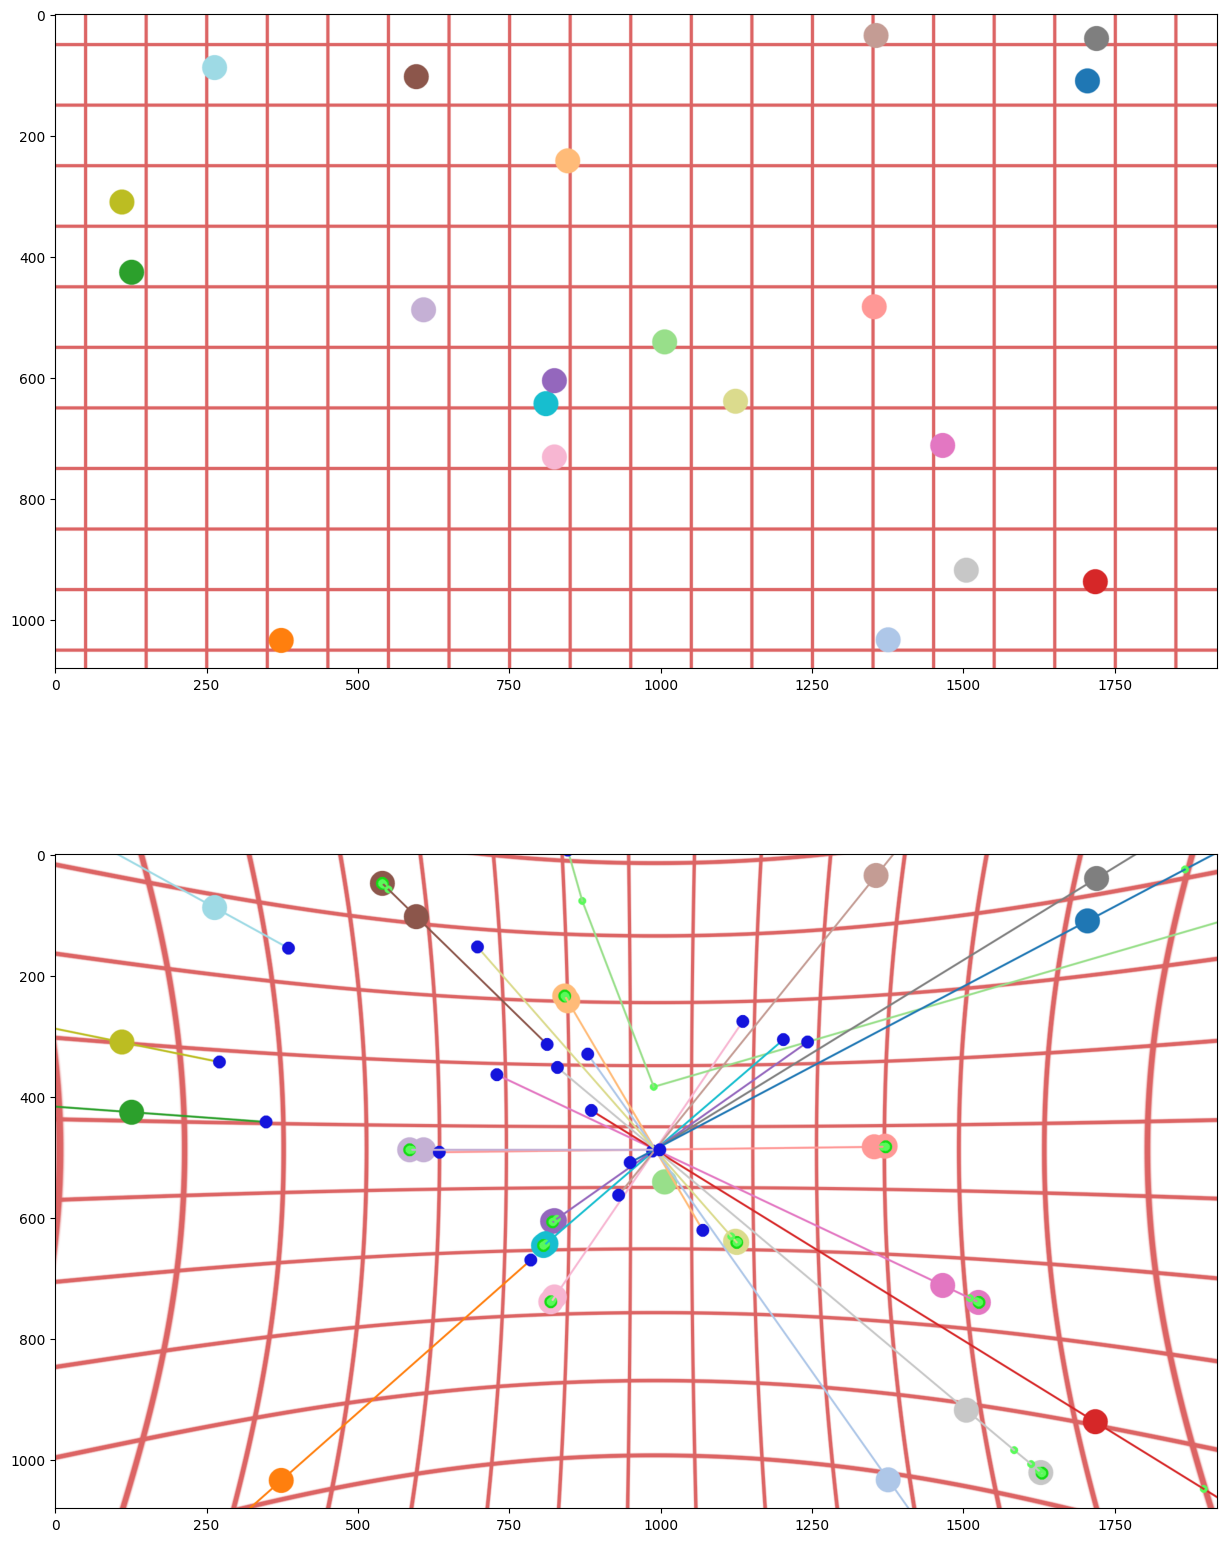

In [34]:

img_und_p_3 = draw_circles(img_und.copy(), circles_und)
img_ind_p_3 = draw_circles(img_und_p_3, circles_src)
for i, c in enumerate(circles_src):
    pp = tuple(np.rint(und_pts[i]).astype(np.int32))
    h = stats.pthist[i]
        
    cv2.circle(img_und_p_3, pp, 10, (20,220,20), -1, cv2.LINE_AA)
    
    for p in h[-2::-1]:
        p = tuple(np.rint(p).astype(np.int32))
        cv2.line(img_und_p_3, pp, p, c['color'], 2, cv2.LINE_AA)
        cv2.circle(img_und_p_3, p, 6, (90, 250, 90), -1, cv2.LINE_AA)
        pp = p
    cv2.circle(img_und_p_3, p, 10, (20,20,220), -1, cv2.LINE_AA)


plt.figure(figsize=(15,20))
plt.subplot(211)
plt.imshow(img_src_p)
plt.subplot(212)
plt.imshow(img_und_p_3)
plt.show()

## Оценка ошибок пространственных преобразований

Пространственные преобразования нелинейно искажают изображение. 
Изначально изображение представлено в виде дискретной сетки пикселей, и нам приходилось пользоваться интерполяцией, чтобы вычислять значенения.
Получается что эффективная площадь пикселей результирующего изображения на самом деле может стать меньше.

Для оценки ошибок, вносимых пространственным преобразованием можно использовать модуль детерминанта якобиана.

In [40]:
def area_resample(rmap_x, rmap_y):
    J_xx = rmap_x[:-1, 1:] - rmap_x[:-1, :-1]
    J_xy = rmap_x[1:, :-1] - rmap_x[:-1, :-1]
    J_yx = rmap_y[:-1, 1:] - rmap_y[:-1, :-1]
    J_yy = rmap_y[1:, :-1] - rmap_y[:-1, :-1]

    return np.abs(J_xx * J_yy - J_xy * J_yx)


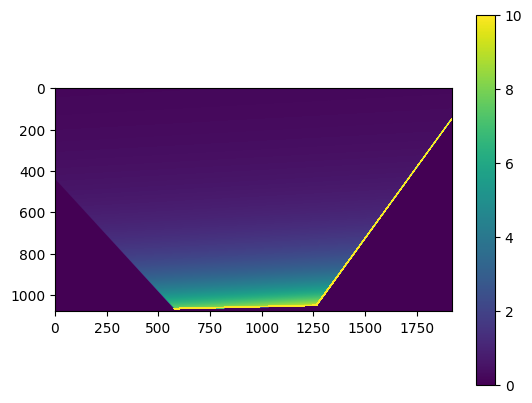

In [47]:
plt.imshow(area_resample(rmap_x_beye, rmap_y_beye), vmin=0, vmax=10)
plt.colorbar()

## Задачи для самостоятельного решения

## Задача 1
Напишите класс для вычисления карты пересчета undistort-преобразования.
Сравните результат с выводом функции cv2.initUndistortRectifyMap

In [35]:
# решение задачи 1

## Задача 2
Вычислить карту пересчета для преобразования undistort в определенной области исходного изображения (ROI + Undistort)

In [36]:
# решение задачи 2

## Задача 3
Вычислить карту пересчета преобразования birdeye после выполнения undistort. Сравнить с результатами birdeye из лекции

In [37]:
# решение задачи 3